In [1]:
import pandas as pd 
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge, Lasso, LassoLarsCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error

In [2]:
raw_data = pd.read_csv('../data/output/mannheim_transformed.csv', parse_dates=['start_time'])

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198384 entries, 0 to 198383
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   bike_number          198384 non-null  int64         
 1   start_time           198384 non-null  datetime64[ns]
 2   weekend              198384 non-null  bool          
 3   start_position       198384 non-null  object        
 4   start_position_name  198384 non-null  object        
 5   duration             198384 non-null  int64         
 6   end_time             198384 non-null  object        
 7   end_position         198384 non-null  object        
 8   end_position_name    198384 non-null  object        
 9   is_station           198384 non-null  bool          
dtypes: bool(2), datetime64[ns](1), int64(2), object(5)
memory usage: 12.5+ MB


In [4]:
raw_data.loc[raw_data['is_station']==True , 'start_position_name'].nunique()

48

In [5]:
raw_data.loc[(raw_data['duration'] <= 180) | (
        raw_data["start_position"] == raw_data["end_position"]), 'false_booking'] = 1
raw_data.fillna(0.0, inplace=True)
false_bookings_series = raw_data['false_booking']

col_to_drop = ['bike_number', 'start_position', 'end_time', 'end_position', 'end_position_name',
               'false_booking']
prediction_data = raw_data.drop(columns=col_to_drop)

In [6]:
# Creating an individual column for hour of the day
prediction_data['HOUR'] = prediction_data.start_time.dt.strftime('%-H').astype('int')

# Creating an individual column for week of the year
prediction_data['WEEK_OF_YEAR'] = prediction_data.start_time.dt.strftime('%W').astype('int')

# Creating an individual column for day of the week
prediction_data['DAY_OF_WEEK'] = prediction_data.start_time.dt.strftime('%w').astype('int')

seasons = []
for month in prediction_data.start_time.dt.strftime('%m').astype('int'):
    if month in [1, 2, 12]:
        seasons.append('WINTER')
    elif month in [3, 4, 5]:
        seasons.append('SPRING')
    elif month in [6, 7, 8]:
        seasons.append('SUMMER')
    elif month in [9, 10, 11]:
        seasons.append('FALL')
prediction_data['season'] = seasons

In [7]:
# Creating fig and subplots
#fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True, sharey=True, dpi=500)

# Plotting the relationship between the actual count and its lagged values
#for i, ax in enumerate(axes.flatten()[:10]):
#    pd.plotting.lag_plot(raw_data.sort_values(by=['start_time'])['duration'], lag=i + 1, ax=ax)
#    ax.set_title('Lag ' + str(i + 1))
#plt.tight_layout();

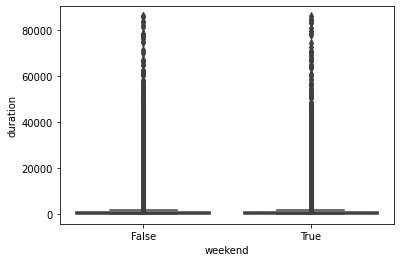

In [8]:
sns.boxplot(x='weekend', y='duration', data=prediction_data)

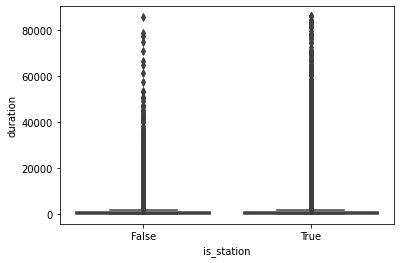

In [9]:
sns.boxplot(x='is_station', y='duration', data=prediction_data)

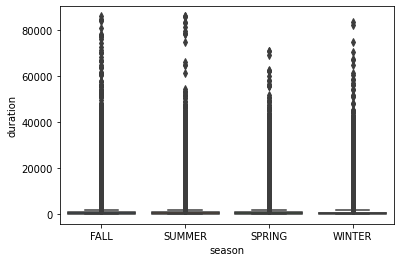

In [10]:
sns.boxplot(x='season', y='duration', data=prediction_data)

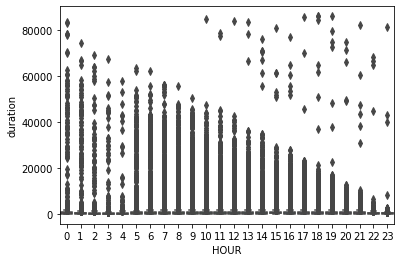

In [11]:
sns.boxplot(x='HOUR', y='duration', data=prediction_data)

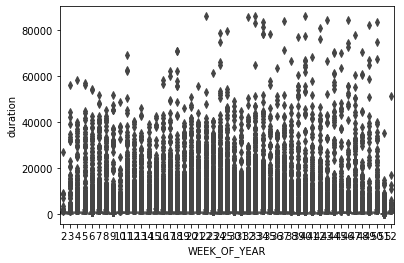

In [12]:
sns.boxplot(x='WEEK_OF_YEAR', y='duration', data=prediction_data)

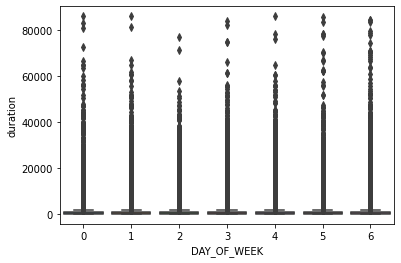

In [13]:
sns.boxplot(x='DAY_OF_WEEK', y='duration', data=prediction_data)

In [14]:
# Applying sine,cosine transformation on column hour to retain the cyclical nature
prediction_data['HOUR_SIN'] = np.sin(prediction_data.HOUR * (2. * np.pi / 24))
prediction_data['HOUR_COS'] = np.cos(prediction_data.HOUR * (2. * np.pi / 24))

In [15]:
# Applying sine,cosine transformation on column WEEK_OF_YEAR to retain the cyclical nature
prediction_data['WEEK_OF_YEAR_SIN'] = np.sin(prediction_data.WEEK_OF_YEAR * (2. * np.pi / 52))
prediction_data['WEEK_OF_YEAR_COS'] = np.cos(prediction_data.WEEK_OF_YEAR * (2. * np.pi / 52))

In [16]:
# Applying sine,cosine transformation on column DAY_OF_WEEK to retain the cyclical nature
prediction_data['DAY_OF_WEEK_SIN'] = np.sin(prediction_data.DAY_OF_WEEK * (2. * np.pi / 7))
prediction_data['DAY_OF_WEEK_COS'] = np.cos(prediction_data.DAY_OF_WEEK * (2. * np.pi / 7))

In [17]:
# hier muss kein drop first weil es ja noch floating starts gibt
station_dummies = pd.get_dummies(prediction_data.loc[raw_data['is_station']==True , 'start_position_name'])

In [18]:
seasonal_dummies = pd.get_dummies(prediction_data['season'], drop_first=True)

In [19]:
# Dropping individual time columns since their transformation will be used
prediction_data.drop(columns=['WEEK_OF_YEAR', 'DAY_OF_WEEK', 'HOUR','start_time','season','start_position_name'], axis=1, inplace=True)

In [20]:
prediction_data = pd.concat([prediction_data, seasonal_dummies, station_dummies], axis=1)

In [21]:
prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198384 entries, 0 to 198383
Data columns (total 60 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   weekend                                         198384 non-null  bool   
 1   duration                                        198384 non-null  int64  
 2   is_station                                      198384 non-null  bool   
 3   HOUR_SIN                                        198384 non-null  float64
 4   HOUR_COS                                        198384 non-null  float64
 5   WEEK_OF_YEAR_SIN                                198384 non-null  float64
 6   WEEK_OF_YEAR_COS                                198384 non-null  float64
 7   DAY_OF_WEEK_SIN                                 198384 non-null  float64
 8   DAY_OF_WEEK_COS                                 198384 non-null  float64
 9   SPRING                    

In [22]:
prediction_data.fillna(0.0, inplace=True)

In [23]:
prediction_data = prediction_data.merge(false_bookings_series, left_index=True, right_index=True)

In [24]:
prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198384 entries, 0 to 198383
Data columns (total 61 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   weekend                                         198384 non-null  bool   
 1   duration                                        198384 non-null  int64  
 2   is_station                                      198384 non-null  bool   
 3   HOUR_SIN                                        198384 non-null  float64
 4   HOUR_COS                                        198384 non-null  float64
 5   WEEK_OF_YEAR_SIN                                198384 non-null  float64
 6   WEEK_OF_YEAR_COS                                198384 non-null  float64
 7   DAY_OF_WEEK_SIN                                 198384 non-null  float64
 8   DAY_OF_WEEK_COS                                 198384 non-null  float64
 9   SPRING                    

In [25]:
X = prediction_data.drop(columns=['duration'])
y = prediction_data['duration'].values.reshape(-1,1)

In [26]:
X_train_solo, X_test_solo, y_train_solo, y_test_solo = train_test_split(X, y, random_state=0)

In [27]:
model = LassoLarsCV(cv=5, normalize=False).fit(X_train_solo, y_train_solo)

/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
y_pred = model.predict(X_train_solo).reshape(-1, 1)

In [29]:
reg_residuals = y_train_solo.reshape(-1, 1) - y_pred

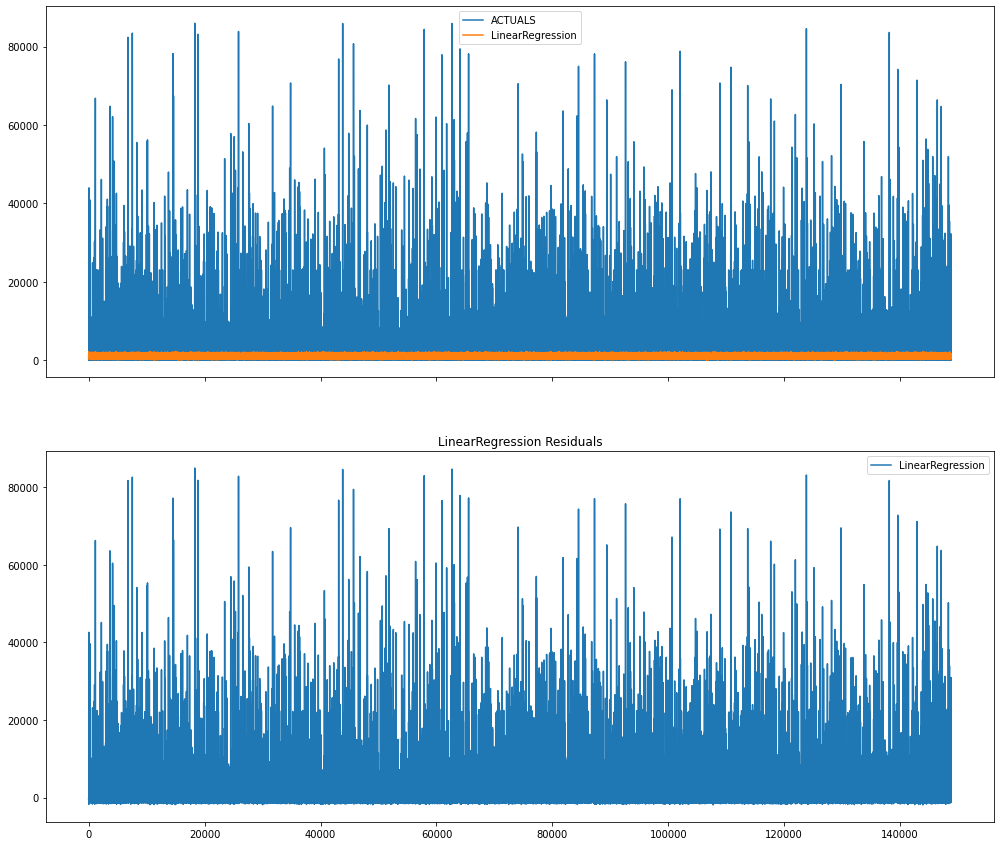

In [30]:
# Creating fit and subplots
fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
pd.DataFrame({'ACTUALS': y_train_solo.reshape(-1),
              'LinearRegression': y_pred.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
pd.DataFrame({'LinearRegression': reg_residuals.reshape(-1)}).plot(ax=axs[1])

axs[1].set_title('LinearRegression Residuals');

In [31]:
y_train_solo.min()

120

In [32]:
mean_absolute_error(y_train_solo, y_pred)

1011.8862521580285

In [33]:
rf_model = RandomForestRegressor(n_jobs=-1, 
                                 random_state=123)

In [34]:
rf_model.fit(X_train_solo, y_train_solo.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [35]:
# Calculating the fit of the model
rf_predictions = rf_model.predict(X_train_solo).reshape(-1)



# Calculating the residuals
rf_residuals = y_train_solo.reshape(-1) - rf_predictions

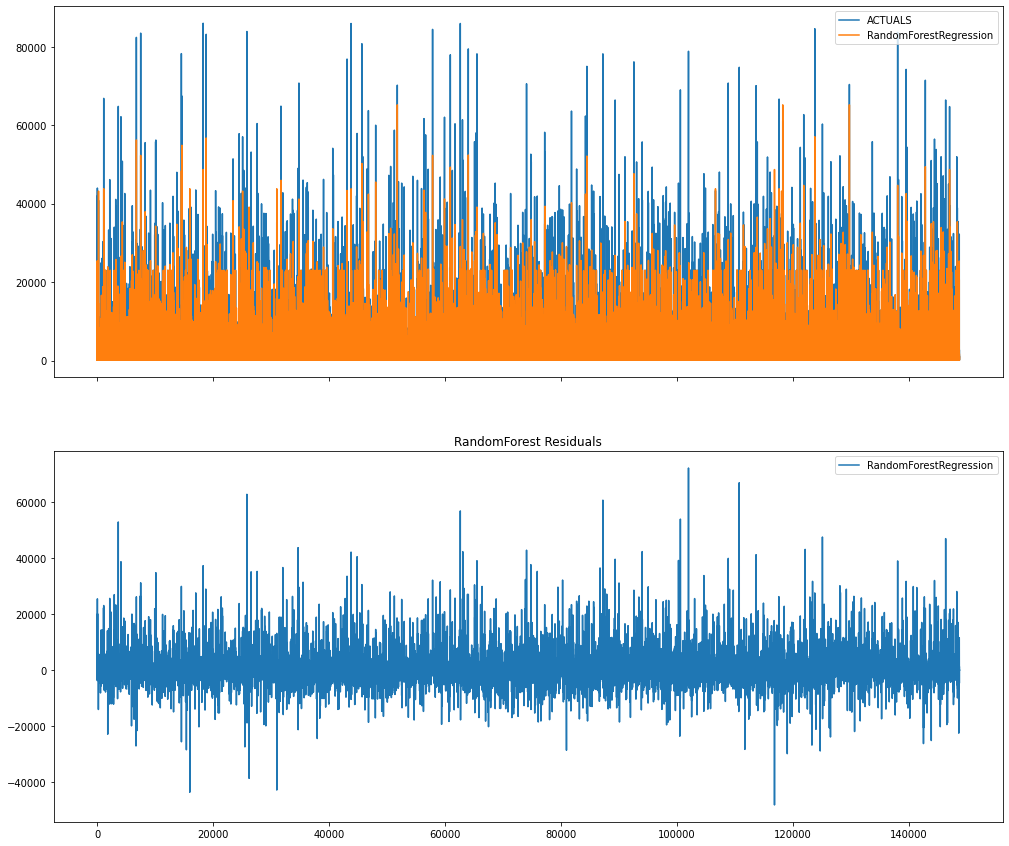

In [36]:
# Creating fit and subplots
fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
pd.DataFrame({'ACTUALS': y_train_solo.reshape(-1),
              'RandomForestRegression': rf_predictions.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
pd.DataFrame({'RandomForestRegression': rf_residuals.reshape(-1)}).plot(ax=axs[1])

axs[1].set_title('RandomForest Residuals');

In [37]:
mean_absolute_error(y_train_solo.reshape(-1), rf_predictions)

484.5223876400298

# Booking Filter

In [38]:
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [39]:
X = prediction_data.drop(columns=['duration', 'false_booking'])
y = prediction_data['false_booking'].values.reshape(-1,1)

In [40]:
rfc = RandomForestClassifier(n_jobs=-1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [42]:
rfc.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [43]:
y_pred = rfc.predict(X_train)

In [44]:
print(sklearn.metrics.accuracy_score(y_true=y_train, y_pred=y_pred))

0.9253703255638895


In [45]:
X_train = np.concatenate((X_train, np.vstack(y_pred)), axis=1)

In [46]:
# Calculating the fit of the model
rf_predictions = rf_model.predict(X_train).reshape(-1)



# Calculating the residuals
rf_residuals = y_train_solo.reshape(-1) - rf_predictions

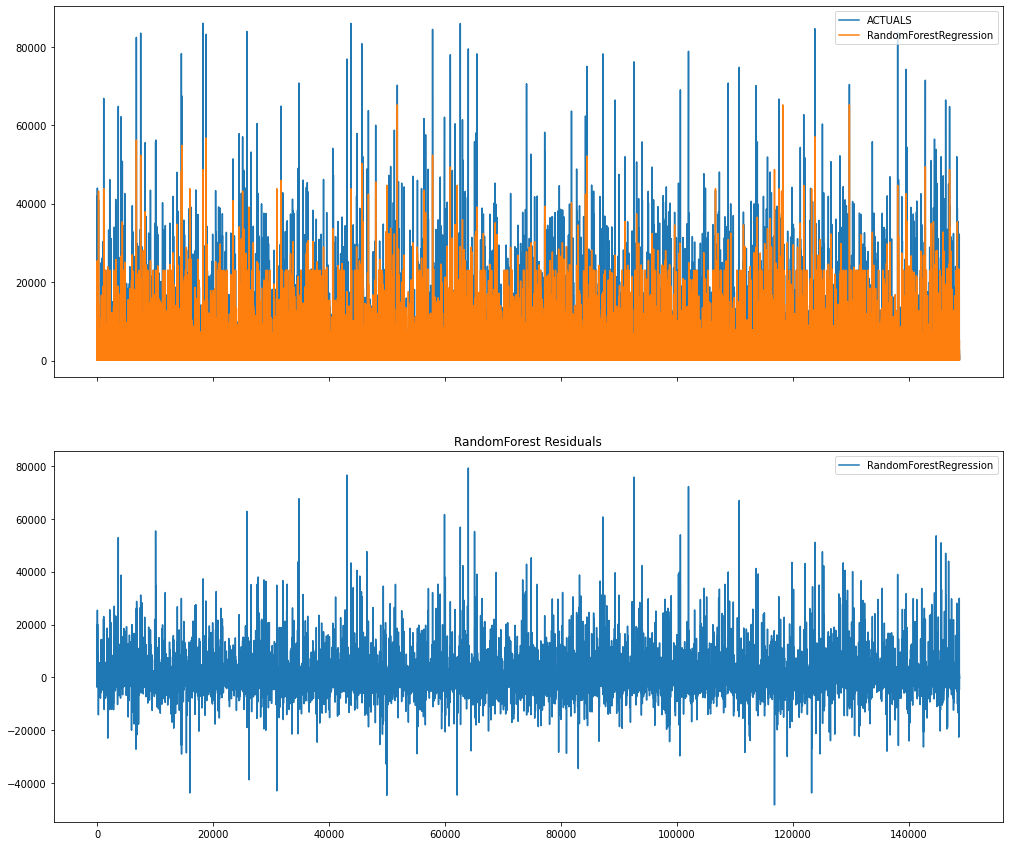

In [47]:
# Creating fit and subplots
fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
pd.DataFrame({'ACTUALS': y_train_solo.reshape(-1),
              'RandomForestRegression': rf_predictions.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
pd.DataFrame({'RandomForestRegression': rf_residuals.reshape(-1)}).plot(ax=axs[1])

axs[1].set_title('RandomForest Residuals');

In [48]:
mean_absolute_error(y_train_solo.reshape(-1), rf_predictions)

556.0321278743373

Grid Search

In [49]:
#rf_mode_opt = RandomForestRegressor(n_jobs=-1, 
#                                 random_state=123,
#                                 n_estimators=800,
#                                 min_samples_split=10,
#                                 min_samples_leaf=4,
#                                 max_features='sqrt',
#                                 max_depth=80,
#                                 bootstrap=True)

In [50]:
#rf_mode_opt.fit(X_train, y_train)

In [51]:
# Calculating the fit of the model
#rf_opt_predictions = rf_mode_opt.predict(X_train).reshape(-1)



# Calculating the residuals
#rf_opt_residuals = y_train.reshape(-1) - rf_opt_predictions

In [52]:
# Creating fit and subplots
#fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
#pd.DataFrame({'ACTUALS': y_train.reshape(-1),
              'OPT_RandomForestRegression': rf_opt_predictions.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
#pd.DataFrame({'RandomForestRegression': rf_opt_residuals.reshape(-1)}).plot(ax=axs[1])

#axs[1].set_title('OPT_RandomForest Residuals');

IndentationError: unexpected indent (<ipython-input-52-7a4e5dbd1bf5>, line 6)

In [ ]:
#mean_absolute_error(y_train.reshape(-1), rf_opt_predictions)

In [ ]:
# Creating fig
#fig = plt.figure(figsize=(20, 10))

# Deriving the feature importances of the optimized and default model
#default_importances = list(rf_model.feature_importances_)
#optimized_importances = list(rf_mode_opt.feature_importances_)

# Creating an array with range of number of variables
#x_values = np.arange(len(default_importances))

# Creating bar plots of optimized and default importances
#plt.bar(x_values, default_importances,orientation='vertical', color='blue', width=.5, align='center', label='Default')
#plt.bar(x_values + 0.5, optimized_importances, orientation='vertical', color='red', width=.5, align='center', label='Optimized')

#plt.xticks(x_values + 0.25, list(X.columns), rotation='vertical')

#plt.ylabel('Importance')
#plt.xlabel('Variable')
#plt.title('Variable Importances')

#plt.legend(loc=1)
#plt.show();

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(20, 90, num = 8)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [ ]:
#rf_random.best_params_